In [141]:
import hitdifferentparts
import IPython.display as ipd
import numpy as np
import autograd
import torch
from kymatio import Scattering1D

from torch.autograd import backward
import matplotlib.pyplot as plt
from tqdm import tnrange, tqdm_notebook

## (x,y)->sounds

drum info: 

$\alpha = 1$

$l = l_2 = \pi$

$\omega_1 = 200Hz$

$\tau_1 = 0.2$

p = 0.3

D = 0

$m_1 = m_2 = 5$


In [2]:
y1 = hitdifferentparts.hitdiffparts(0.5,0.5)
ipd.Audio(y1,rate=sr)

--- 1.4723587036132812 seconds ---


## Sample from 1/8 th of a drum surface

## interpolate sounds from two adjacent points (0.5,0.5) and (0.4,0.5)

In [140]:
N = 2**16 #length of auido signal
J = 4

In [133]:
def getsc(y, J):
    """
    this function outputs scattering transform of a time-domain signal.
    """
    N = len(y)
    scattering = Scattering1D(J = J,shape=(N,))
    Sy = scattering(y)
    return Sy

def interpolate_sounds(x_coord,y_coord,num,prec):
        """
        x_coord, y_coord is the point at which you want to interpolate the sounds
        num is number of interpolation points
        prec is distance between interpolated to interpolation points
        """
        scs = []
        sounds = []
        if num == 2:
            inter = [(x_coord+prec,y_coord),(x_coord-prec,y_coord)]
        elif num == 4:
            inter = [(x_coord+prec,y_coord),(x_coord-prec,y_coord),(x_coord,y_coord+prec),(x_coord,y_coord-prec)]
        for (x,y) in inter:
            y = hitdifferentparts.hitdiffparts(x,y)
            Sy = getsc(torch.Tensor(y),J)
            sounds.append(y)
            scs.append(Sy)
        return sum(scs)/float(num),sounds



In [147]:
Sc_interpolated,sounds = interpolate_sounds(0.45,0.5,4,0.05)

--- 1.6224141120910645 seconds ---
--- 1.5522990226745605 seconds ---
--- 1.6112911701202393 seconds ---
--- 1.272022008895874 seconds ---


In [183]:
ipd.Audio(sounds[0],rate=sr)

In [184]:
ipd.Audio(sounds[1],rate=sr)

In [185]:
ipd.Audio(sounds[2],rate=sr)

In [186]:
ipd.Audio(sounds[3],rate=sr)

In [187]:
ipd.Audio(y_gt,rate=sr)

In [195]:
y_norm = np.sum(np.array(sounds),axis=0)/4.0
ipd.Audio(y_norm,rate=sr)

In [198]:
np.sum(y_gt-y_norm)

-0.20157318994381887

In [201]:
np.sum(y_gt-list(y_interpolated))

tensor(5.1413, grad_fn=<AddBackward0>)

In [10]:
print(len(y_1),len(y_2),2**16)

65536 65536 65536


In [1]:
def regress_signal(
        s_c, N, J,
        learning_rate=0.1,
        momentum=0.0,
        NAG = False,
        bold_driver_accelerator=1.1,
        bold_driver_brake=0.5,
        n_iterations=100,
        cost = "mse",
        verbose=False):
    """
    this function finds time-domain signal from scattering transform
    input: scattering tranform tensor, length of the signal(implicitly), learning rate and number of iterations
    output: time-domain signal represented in a tensor
    """
    scattering = Scattering1D(J=J,shape=(N,)) #N is length of signal, J is number of scales
    if cost == "cross-entropy":
        loss = torch.nn.KLDivLoss()
    
    #random guess
    x = torch.randn((N,),requires_grad=True)
    Sx = scattering(x)
    #target
    Sy = s_c
    history = []
    signal_update = 0*x
    #iterate to regress random guess to be close to target
    for it_id in tqdm_notebook(range(n_iterations), disable=not verbose):
        # Backpropagation
        if cost == "mse":
            err = torch.norm(Sx-Sy)
            #backward(torch.norm(Sx - Sy))
        elif cost == "cross-entropy":
            #Sy = Sy.long()
            #np.sum(yHat * np.log((yHat / y)))
            Sx_normalize = Sx.normalize()
            err = loss(Sx,Sy)
            #backward(loss(Sx, Sy))         
        backward(err)
        if NAG == False:
            delta_x = x.grad
    
        else:
            # for some reasons this nag doesn't have gradient!
            nag_x = torch.tensor(momentum * signal_update + x, requires_grad = True)
            print(nag_x.grad)
            delta_x = torch.Tensor(torch.conomentum * signal_update + x).grad
            print(delta_x)
            
        #print(x.grad)

        # Gradient descent
        with torch.no_grad():
            momentum = min(0.99,1-2**(-1-np.log(np.floor(it_id/250)+1)/np.log(2))) #according to 
            signal_update = momentum * signal_update - delta_x * learning_rate
            new_x = x + signal_update
        new_x.requires_grad = True

        # New forward propagation
        Sx = scattering(new_x)
        # Measure the new loss
        history.append(err)
        
        if history[it_id]> history[it_id-1]:
            learning_rate *= bold_driver_brake
        else:
            learning_rate *= bold_driver_accelerator
            x = new_x
        #print(torch.norm(Sx - Sy))
        
        #print("lr = {:6.3f}     loss={:6.3f}".format(learning_rate, history[-1]))
        
    return x,history

In [2]:
it_id=300
1-2**(-1-np.log(np.floor(it_id/250)+1)/np.log(2))

NameError: name 'np' is not defined

A Jupyter Widget

Text(0.5, 1.0, '4-point mse, bold driver accelerator 1.1,brake 0.6, momentum 0.9')

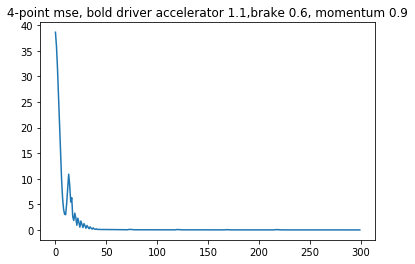

In [221]:
y_interpolated,history = regress_signal(
    Sc_interpolated, N, J, learning_rate=100, 
    bold_driver_accelerator=1.1,
    bold_driver_brake=0.6,
    momentum=0.9, 
    NAG = False,
    n_iterations=300, 
    cost = "mse", 
    verbose=True)
plt.plot(history)
plt.title('4-point mse, bold driver accelerator 1.1,brake 0.6, nag adaptive momentum')

In [222]:
print(history[-1])
ipd.Audio(list(y_interpolated),rate=sr)

tensor(0.0157, grad_fn=<NormBackward0>)


In [168]:
Sc_normalized = (Sc_interpolated - Sc_interpolated.mean().mean())/Sc_interpolated.std().std()
print(Sc_interpolated.min(),Sc_normalized.min(),Sc_interpolated.mean().mean(),Sc_normalized)

tensor(-0.3327) tensor(nan) tensor(0.0003) tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])


cost function MSE experiments

A Jupyter Widget

Text(0.5, 1.0, '2-point mse')

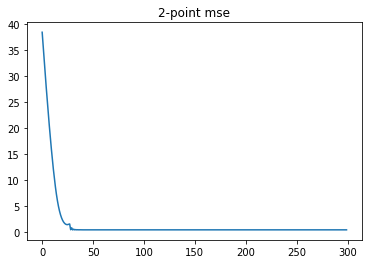

In [153]:
y_interpolated,history = regress_signal(
    Sy_interpolated, N, J, learning_rate=100, 
    bold_driver_accelerator=1.0,
    bold_driver_brake=0.5,
    momentum=0.0, n_iterations=300, cost = "mse", verbose=True)
plt.plot(history)
plt.title('2-point mse')

In [154]:
print(history[-1])
ipd.Audio(list(y_interpolated),rate=sr)

tensor(0.4700, grad_fn=<NormBackward0>)


A Jupyter Widget

Text(0.5, 1.0, '2-point mse, bold driver accelerator 1.1')

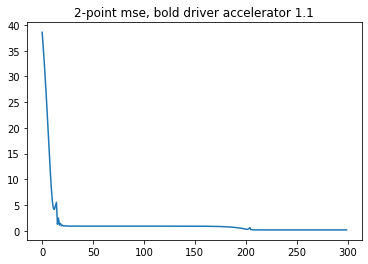

In [145]:
y_interpolated,history = regress_signal(
    Sy_interpolated, N, J, learning_rate=100, 
    bold_driver_accelerator=1.1,
    bold_driver_brake=0.5,
    momentum=0.0, n_iterations=300, cost = "mse", verbose=True)
plt.plot(history)
plt.title('2-point mse, bold driver accelerator 1.1')

In [146]:
print(history[-1])
ipd.Audio(list(y_interpolated),rate=sr)

tensor(0.1448, grad_fn=<NormBackward0>)


A Jupyter Widget

Text(0.5, 1.0, '4-point mse, bold driver accelerator 1.1')

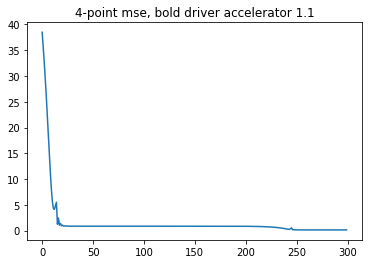

In [148]:
y_interpolated,history = regress_signal(
    Sc_interpolated, N, J, learning_rate=100, 
    bold_driver_accelerator=1.1,
    bold_driver_brake=0.5,
    momentum=0.0, n_iterations=300, cost = "mse", verbose=True)
plt.plot(history)
plt.title('4-point mse, bold driver accelerator 1.1')

In [149]:
print(history[-1])
ipd.Audio(list(y_interpolated),rate=sr)

tensor(0.1422, grad_fn=<NormBackward0>)


A Jupyter Widget

Text(0.5, 1.0, '4-point mse, bold driver accelerator 1.1,brake 0.6')

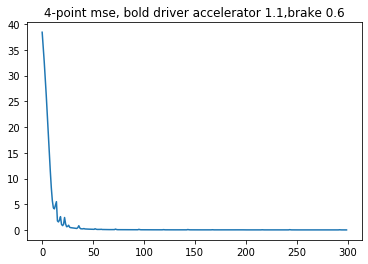

In [150]:
y_interpolated,history = regress_signal(
    Sc_interpolated, N, J, learning_rate=100, 
    bold_driver_accelerator=1.1,
    bold_driver_brake=0.6,
    momentum=0.0, n_iterations=300, cost = "mse", verbose=True)
plt.plot(history)
plt.title('4-point mse, bold driver accelerator 1.1,brake 0.6')

In [151]:
print(history[-1])
ipd.Audio(list(y_interpolated),rate=sr)

tensor(0.0219, grad_fn=<NormBackward0>)


A Jupyter Widget

Text(0.5, 1.0, '4-point mse, bold driver accelerator 1.1,brake 0.6, momentum 1')

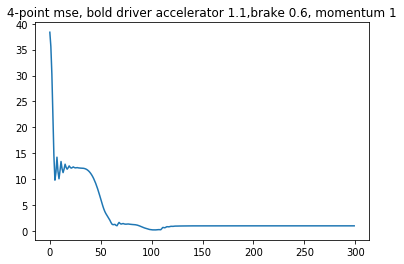

In [170]:
y_interpolated,history = regress_signal(
    Sc_interpolated, N, J, learning_rate=100, 
    bold_driver_accelerator=1.1,
    bold_driver_brake=0.6,
    momentum=0.9, 
    NAG = False,
    n_iterations=300, 
    cost = "mse", 
    verbose=True)

plt.plot(history)
plt.title('4-point mse, bold driver accelerator 1.1,brake 0.6, momentum 0.9')

In [171]:
print(history[-1])
ipd.Audio(list(y_interpolated),rate=sr)

tensor(0.9915, grad_fn=<NormBackward0>)


NAG momentum - Sutskever et al. 2013

In [172]:
y_interpolated,history = regress_signal(
    Sc_interpolated, N, J, learning_rate=100, 
    bold_driver_accelerator=1.1,
    bold_driver_brake=0.6,
    momentum=0.9, 
    NAG = True,
    n_iterations=300, 
    cost = "mse", 
    verbose=True)
plt.plot(history)
plt.title('4-point mse, bold driver accelerator 1.1,brake 0.6, momentum 0.9')

A Jupyter Widget

TypeError: unsupported operand type(s) for *: 'NoneType' and 'int'

cost function cross entropy experiments

A Jupyter Widget

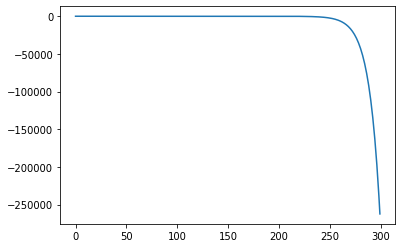

In [88]:
y_interpolated,history = regress_signal(
    Sy_interpolated, N, J, learning_rate=100, 
    bold_driver_accelerator=1.1,
    bold_driver_brake=0.5,
    momentum=0.0, n_iterations=300, cost = "cross-entropy", verbose=True)
plt.plot(history)

tensor(-262452.9688, grad_fn=<KlDivBackward>)


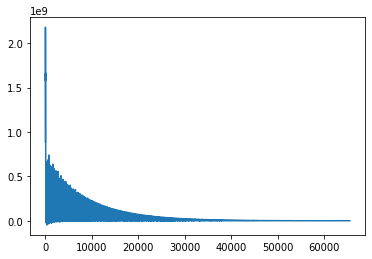

In [95]:
print(history[-1])
#ipd.Audio(list(y_interpolated),rate=sr)
plt.plot((list(y_interpolated)))

ground truth sound at (0.45,0.5)

In [142]:
y_gt = hitdifferentparts.hitdiffparts(0.45,0.5)
ipd.Audio(y_gt,rate=sr)

--- 1.4069509506225586 seconds ---


In [64]:
Sy1.shape

torch.Size([13, 4096])

In [78]:
distance = np.linalg.norm(Sy1-Sy2)
Sy_mid = Sy1-distance

In [91]:
y_gt = hitdifferentparts.hitdiffparts(0.45,0.5)
ipd.Audio(y_gt,rate=sr)

--- 1.8833122253417969 seconds ---


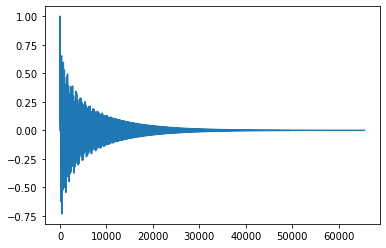

In [97]:
plt.plot(y_gt)

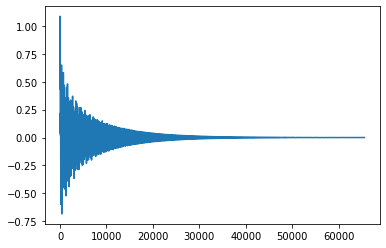

In [26]:
plt.plot(np.array(list(y_interpolated)))

## Kymatio

In [3]:
import torch
from kymatio import Scattering1D

In [4]:
# Set the parameters of the scattering transform.
J = 6
T = 2**13
Q = 8

# Generate a sample signal.
x = torch.randn(1, 1, T)

# Define a Scattering1D object.
S = Scattering1D(J, T, Q)

# Calculate the scattering transform.
Sx = S.forward(x)

In [6]:
print(Sx,Sx.shape)

tensor([[[[-6.2078e-02, -5.3912e-02, -3.8472e-02,  ...,  1.0951e-01,
            1.2154e-01,  1.1615e-01],
          [ 1.6576e-01,  1.6780e-01,  1.7115e-01,  ...,  1.6913e-01,
            1.6445e-01,  1.6491e-01],
          [ 1.3826e-01,  1.3922e-01,  1.4269e-01,  ...,  1.4335e-01,
            1.2972e-01,  1.2100e-01],
          ...,
          [ 1.7812e-05,  1.9328e-05,  2.4117e-05,  ...,  1.7512e-05,
            1.7597e-05,  1.6978e-05],
          [ 2.7673e-05,  2.8760e-05,  3.0415e-05,  ...,  2.0723e-05,
            2.1456e-05,  2.2471e-05],
          [ 6.2213e-06,  7.0801e-06,  9.3679e-06,  ...,  3.5884e-05,
            3.4487e-05,  3.2453e-05]]]]) torch.Size([1, 1, 126, 128])


## Kymatio

In [8]:
import torch
from kymatio import Scattering1D
from kymatio.scattering1d.filter_bank import scattering_filter_factory

In [20]:
T = len(y1)
np.log2(T)

16.428491035332247

example filterbank

In [23]:
# Set the parameters of the scattering transform.
J = 6 #largest filter would cover 2**6 in time (window size?)
T = 2**13 #signal length
#T = len(y1)
Q = 8 #usually between 4 and 16, filterbank divides the octave in Q parts


phi_f, psi1_f, psi2_f, _ = scattering_filter_factory(np.log2(T), J, Q)

Text(0.5, 1.0, 'First-order filters (Q = 8)')

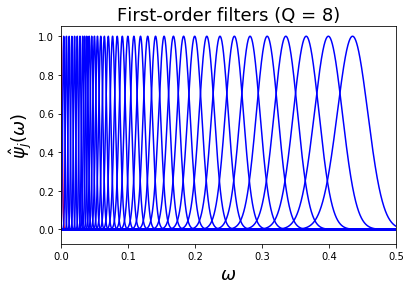

In [24]:
plt.figure()
plt.plot(np.arange(T)/T, phi_f[0], 'r')

for psi_f in psi1_f:
    plt.plot(np.arange(T)/T, psi_f[0], 'b')

plt.xlim(0, 0.5)

plt.xlabel(r'$\omega$', fontsize=18)
plt.ylabel(r'$\hat\psi_j(\omega)$', fontsize=18)
plt.title('First-order filters (Q = {})'.format(Q), fontsize=18)

convert generated signal to torch tensor before carrying out scattering trasform

In [29]:
# Generate a sample signal.
x = torch.from_numpy(y1).float()
x /= x.abs().max()
x = x.view(1, -1)
# Set scattering transform parameters
T = x.shape[-1]
J = 6
Q = 16
# Define a Scattering1D object.
S = Scattering1D(J, T, Q)

# Calculate the scattering transform.
Sx = S.forward(x)

In [36]:
meta = Scattering1D.compute_meta_scattering(J, Q)
order0 = (meta['order'] == 0)
order1 = (meta['order'] == 1)
order2 = (meta['order'] == 2)
print(order0,order1,order2)

tensor([ True, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False]) tensor([False

Text(0.5, 1.0, 'Original signal')

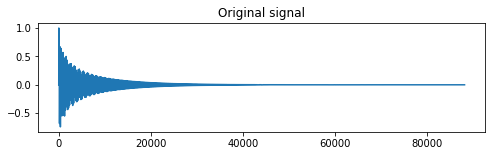

In [33]:
plt.figure(figsize=(8, 2))
plt.plot(x[0,:].numpy())
plt.title('Original signal')

Text(0.5, 1.0, 'Scattering Order 0')

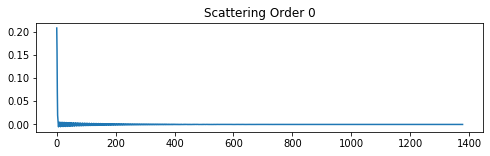

In [37]:
plt.figure(figsize=(8, 2))
plt.plot(Sx[0,order0,:].numpy().ravel())
plt.title('Scattering Order 0')

Text(0.5, 1.0, 'Scattering Order 1')

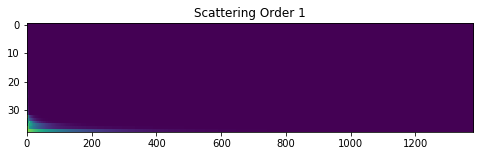

In [38]:
plt.figure(figsize=(8, 2))
plt.imshow(Sx[0,order1,:].numpy(), aspect='auto')
plt.title('Scattering Order 1')

Text(0.5, 1.0, 'Scattering Order 2')

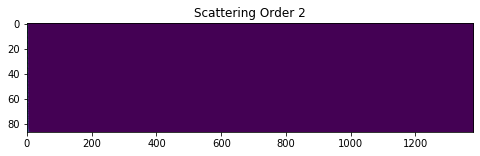

In [39]:
plt.figure(figsize=(8, 2))
plt.imshow(Sx[0,order2,:].numpy(), aspect='auto')
plt.title('Scattering Order 2')

## reconstruct signals from scattering coefficients

In [237]:
Sc = np.maximum(1e-6, Sc_interpolated.numpy())

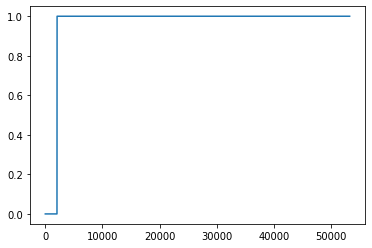